In [1]:
CUDA_DEVICE = "1"

In [2]:
import numpy as np
from PIL import Image
import json
import os
import copy
import argparse
from tqdm import tqdm
import notebook_mesh_utils as nu

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["CUDA_VISIBLE_DEVICES"] = CUDA_DEVICE

from tomo2mesh.projects.steel_am.coarse2fine import coarse_map, process_subset
from tomo2mesh.misc.voxel_processing import TimerGPU
from tomo2mesh.structures.voids import Voids
from tomo2mesh.porosity.params_3dunet import *
from tomo2mesh.unet3d.surface_segmenter import SurfaceSegmenter
from tomo2mesh.fbp.recon import recon_slice, recon_binned, recon_all

import cupy 
import tomo2mesh.fbp.subset as subset
import cupyx.scipy as cpsp
import tomo2mesh.misc.voxel_processing as vp
import skimage.filters as filters
import scipy as sp
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
metadata_fp = '/home/beams/S1IDUSER/mnt/orthros/faber_mar21_data/faber_mar21/metadata/faber_mar21/faber_sam1_s13_crack_tomo/faber_sam1_s13_crack_tomo_TomoFastScan.dat'
override_path = '/home/beams/S1IDUSER/mnt/orthros/faber_mar21_data/faber_mar21/tomo/faber_sam1_s13_crack_tomo'

scans = nu.extract_scan_data(metadata_fp, override_path)
nu.print_avail_scans(scans)

[0]: [175817, 177647]
[1]: [177648, 179478]
[2]: [179479, 181309]
[3]: [181311, 183141]
[4]: [183142, 184972]
[5]: [184973, 186803]
[6]: [186804, 188634]
[7]: [188635, 190465]
[8]: [190466, 192296]
[9]: [192297, 194127]
[10]: [194128, 195958]
[11]: [195959, 197789]
[12]: [197790, 199620]
[13]: [199621, 201451]


In [4]:
scan = scans[1]
scan

ScanMetaData(img_range=[177648, 179478], omega=array([-180. , -179.8, -179.6, ...,  179.6,  179.8,  180. ]), img_dir='/home/beams/S1IDUSER/mnt/orthros/faber_mar21_data/faber_mar21/tomo/faber_sam1_s13_crack_tomo', img_prefix='faber_sam1_s13_crack_tomo')

In [5]:
scan_data = nu.load_images(scan, 10)

Loading Imgs: 100%|██████████| 1831/1831 [00:09<00:00, 185.32it/s]


In [6]:
print(scan_data.projs.shape)
print(scan_data.dark_fields.shape)
print(scan_data.white_fields.shape)
print(scan_data.omega.shape)

(1200, 1801, 1920)
(1200, 10, 1920)
(1200, 20, 1920)
(1801,)


In [7]:
# Reconstruction Parms
# ds = downsampling factor
pixel_ds = 2
scan_ds = 2

scan_data.center = scan_data.projs.shape[-1] / 2.0# assuming that object is perfectly centered
print('Assuming object is perfectly centered...')
scan_data.center += 8

scan_data = nu.downsample_scan(scan_data, pixel_ds, scan_ds)

Assuming object is perfectly centered...


In [8]:
scan_data = nu.norm_whitefield(scan_data)

In [9]:
gpu_batch_size = 50
recon = nu.reconstruct(
    scan_data,
    gpu_batch_size=gpu_batch_size
)
recon_original = copy.deepcopy(recon)

(600, 901, 960)


100%|██████████| 12/12 [00:03<00:00,  3.20it/s]


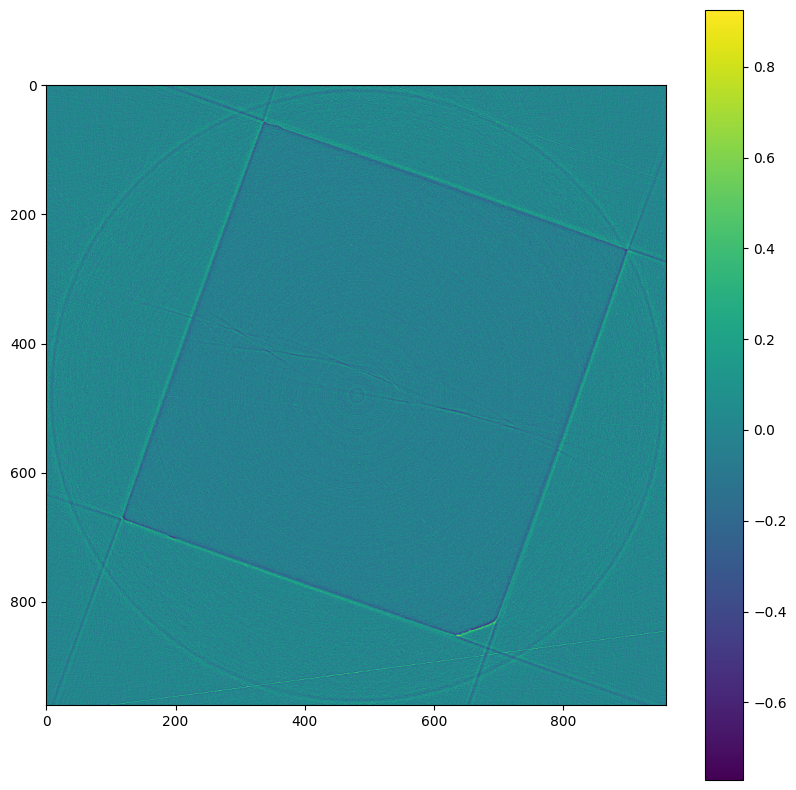

In [10]:
_ = nu.plot_recon(recon_original, 110)

In [11]:
print(recon.shape)
print(type(recon))

(600, 960, 960)
<class 'numpy.ndarray'>


In [12]:
# Can be used to reset reconstruction
recon = copy.deepcopy(recon_original) 

In [13]:
# Insert reconstruction pipeline here
recon[:] = sp.ndimage.gaussian_filter(recon, 0.5)

# binarize
voxel_values = vp.get_values_cyl_mask(recon[::2,::2,::2], 1.0)
rec_min_max = vp.modified_autocontrast(voxel_values, s=0.01)
thresh = np.float32(filters.threshold_otsu(voxel_values))    
recon[:] = (recon<thresh).astype(np.uint8)

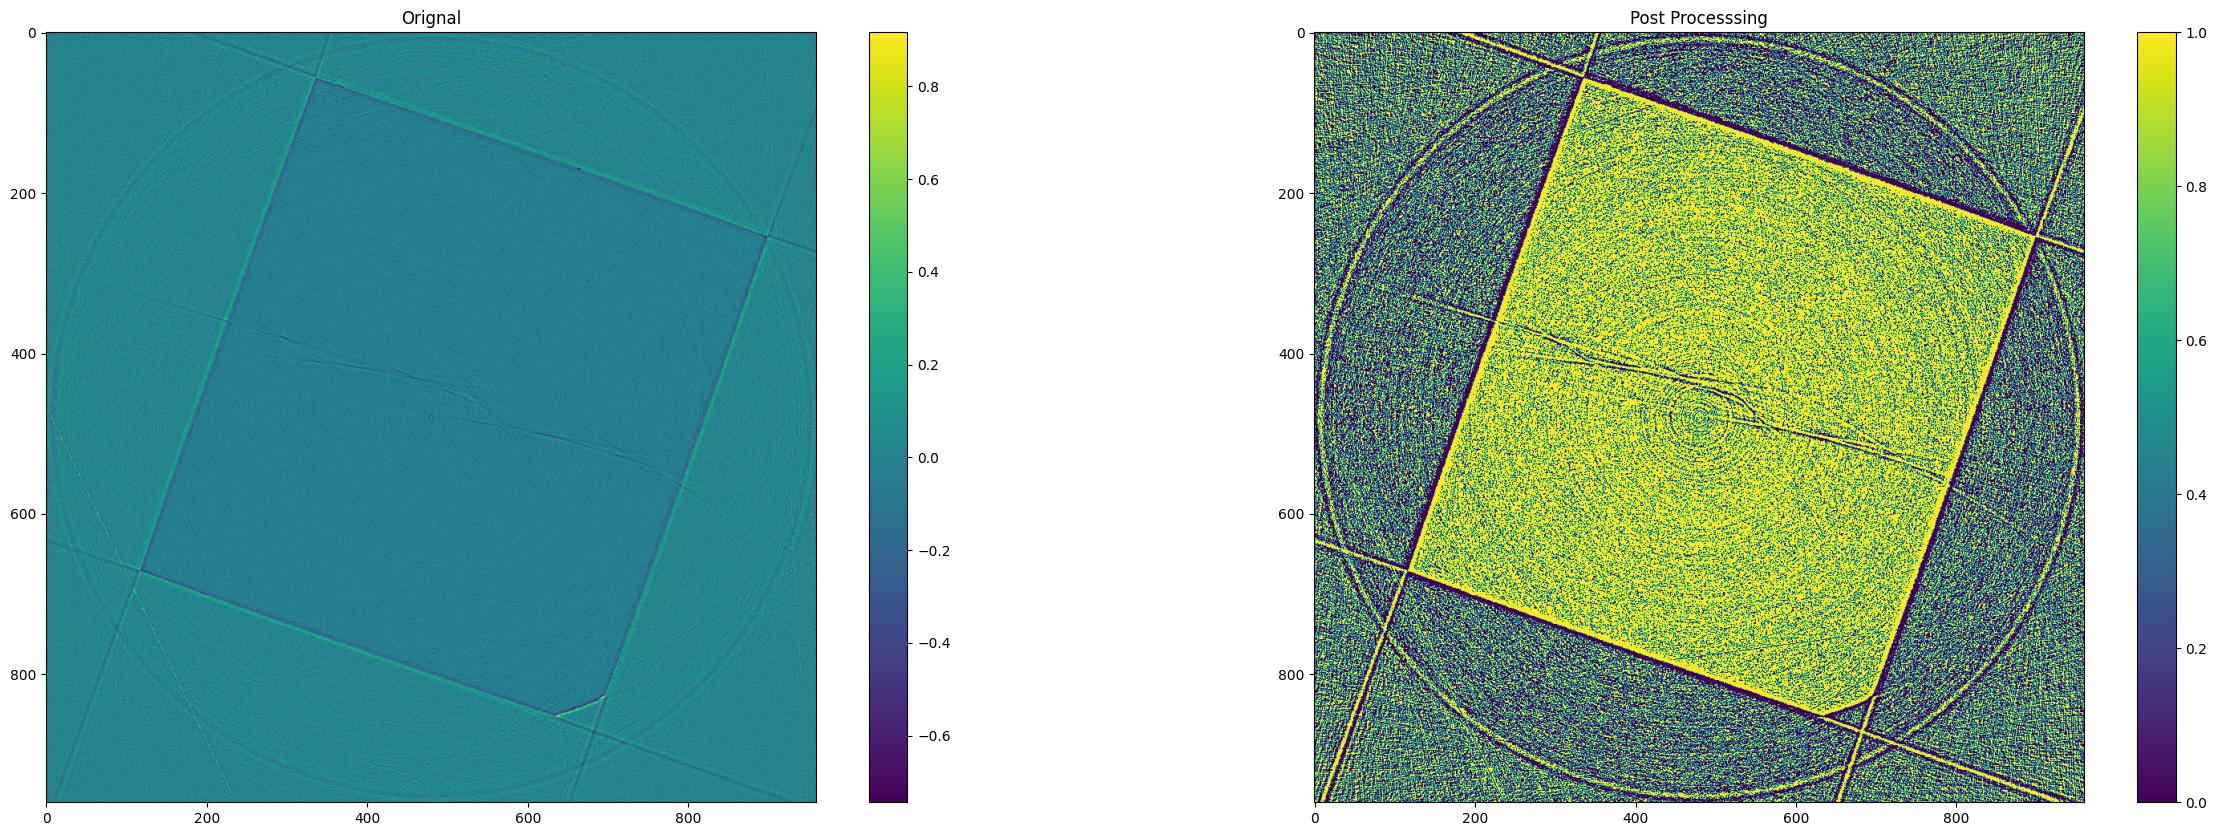

In [19]:
im_layer = 100 

w_ = nu.plot_recon_compare(recon_original, recon, im_layer)

In [15]:
recon_labels, _ = sp.ndimage.label(recon, structure=np.ones((3,3,3), dtype=np.uint8))
voids_b = Voids().count_voids(recon_labels, pixel_ds, dust_thresh=1, pad_bb=2)    

	STAT: voids found - 5992


In [16]:
# Insert polygon pipeline here
#del projs, projs_original
#del recon, recon_original

In [18]:
output_path = 'working_dir/pipeline_out/recon_faber.ply'


voids_b.export_void_mesh_mproc("sizes", edge_thresh=0).write_ply(
    os.path.join(output_path))

void2mesh_mproc: preserve_feature : False, edge_thres : 0, b : 2, nprocs : None


Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


MemoryError: 

Exception ignored in: 'skimage.measure._marching_cubes_lewiner_cy.Cell._increase_size_faces'
Traceback (most recent call last):
  File "/home/beams/S1IDUSER/opt/anaconda3/envs/tomo2mesh39/lib/python3.9/site-packages/skimage/measure/_marching_cubes_lewiner.py", line 198, in _marching_cubes_lewiner
    vertices, faces, normals, values = func(volume, level, L,
MemoryError: 


KeyboardInterrupt: 